In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Importacion de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# reportes de clasificacion
from sklearn.metrics import classification_report, roc_auc_score

# Optimizacion de hiperparametros
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


# Importacion de dataset

In [2]:
df = pd.read_csv("./gnl_mantenimiento_predictivo_balanceado.csv")
df.head()

,timestamp,machine_id,modo_operacion,temperatura_ambiente_c,temperatura_entrada_c,temperatura_salida_c,delta_temp_c,presion_entrada_bar,presion_salida_bar,delta_presion_bar,flujo_masico_kgs,vibracion_rms_mms,velocidad_rpm,potencia_kw,consumo_energia_kwh,horas_operacion,humedad_relativa_pct,fallo
0,2025-07-01 13:37:00,compresor_criogenico_01,Normal,18.61,22.51,116.79,94.28,41.62,178.80,137.17,111.32,3.272,2872,92.43,2.014,8645,66.5,0
1,2025-07-04 02:27:00,compresor_criogenico_01,Baja carga,14.80,20.71,107.81,87.09,53.95,178.02,124.07,78.37,2.236,2912,62.22,0.069,2288,63.6,0
2,2025-07-04 00:50:00,compresor_criogenico_01,Normal,16.21,22.50,126.03,103.53,44.44,183.82,139.38,115.72,2.290,3020,129.98,2.266,6184,64.1,0
3,2025-07-03 20:37:00,compresor_criogenico_01,Normal,10.04,15.88,116.09,100.21,45.49,171.51,126.02,93.30,2.652,3177,83.30,0.372,3409,49.0,1
4,2025-07-03 11:38:00,compresor_criogenico_01,Normal,19.93,24.93,115.96,91.03,44.58,204.56,159.98,93.48,3.813,2967,87.65,1.352,9421,92.0,1


# Informacion de dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               5000 non-null   object 
 1   machine_id              5000 non-null   object 
 2   modo_operacion          5000 non-null   object 
 3   temperatura_ambiente_c  5000 non-null   float64
 4   temperatura_entrada_c   5000 non-null   float64
 5   temperatura_salida_c    5000 non-null   float64
 6   delta_temp_c            5000 non-null   float64
 7   presion_entrada_bar     5000 non-null   float64
 8   presion_salida_bar      5000 non-null   float64
 9   delta_presion_bar       5000 non-null   float64
 10  flujo_masico_kgs        5000 non-null   float64
 11  vibracion_rms_mms       5000 non-null   float64
 12  velocidad_rpm           5000 non-null   int64  
 13  potencia_kw             5000 non-null   float64
 14  consumo_energia_kwh     5000 non-null   

# Analisis de desbalance de clases

fallo
0    3500
1    1500
Name: count, dtype: int64
fallo
0    0.7
1    0.3
Name: proportion, dtype: float64


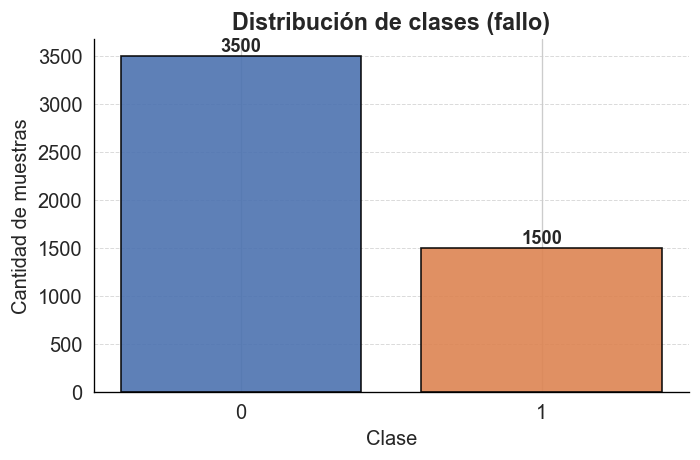

In [4]:
# Cantidad de registros por clase
print(df["fallo"].value_counts())

# Proporcion de clases
print(df["fallo"].value_counts(normalize=True))


# GRAFICOS (COMPARACION DE CLASES)
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'axes.edgecolor': 'black'})

# Conteo de clases
counts = df["fallo"].value_counts()
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
colors = ['#4C72B0', '#DD8452']
bars = ax.bar(counts.index.astype(str), counts.values, color=colors, alpha=0.9, edgecolor='black')
ax.set_title("Distribución de clases (fallo)", fontsize=14, weight='bold')
ax.set_xlabel("Clase", fontsize=12)
ax.set_ylabel("Cantidad de muestras", fontsize=12)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2,
            height + 5,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=11,
            fontweight='semibold')
ax.yaxis.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
ax.set_axisbelow(True)
sns.despine()
plt.tight_layout()
plt.show()

# Separacion de datos de entrada y salida

In [5]:
target = "fallo"
cat_cols = ["modo_operacion", "machine_id"]
num_cols = [c for c in df.columns if c not in cat_cols + [target, "timestamp"]]

# datos de entrada y salida (Modelo supervisado)
X = pd.get_dummies(df[cat_cols + num_cols], drop_first=True, dtype = int)
y = df[target].astype(int)

X.head()

,temperatura_ambiente_c,temperatura_entrada_c,temperatura_salida_c,delta_temp_c,presion_entrada_bar,presion_salida_bar,delta_presion_bar,flujo_masico_kgs,vibracion_rms_mms,velocidad_rpm,potencia_kw,consumo_energia_kwh,horas_operacion,humedad_relativa_pct,modo_operacion_Baja carga,modo_operacion_Normal
0,18.61,22.51,116.79,94.28,41.62,178.80,137.17,111.32,3.272,2872,92.43,2.014,8645,66.5,0,1
1,14.80,20.71,107.81,87.09,53.95,178.02,124.07,78.37,2.236,2912,62.22,0.069,2288,63.6,1,0
2,16.21,22.50,126.03,103.53,44.44,183.82,139.38,115.72,2.290,3020,129.98,2.266,6184,64.1,0,1
3,10.04,15.88,116.09,100.21,45.49,171.51,126.02,93.30,2.652,3177,83.30,0.372,3409,49.0,0,1
4,19.93,24.93,115.96,91.03,44.58,204.56,159.98,93.48,3.813,2967,87.65,1.352,9421,92.0,0,1


# Separacion de datos de entrenamiento, validacion y test

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

# Escalado de covariables

In [7]:
num_cols = [c for c in X.columns if not c.startswith("modo_operacion_") and c != "machine_id"]
scaler = StandardScaler()
X_train.loc[:, num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid.loc[:, num_cols] = scaler.transform(X_valid[num_cols])
X_test.loc[:, num_cols]  = scaler.transform(X_test[num_cols])

C:\Users\Javier\AppData\Local\Temp\ipykernel_29256\2059669114.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.93829557 -0.06397013 -2.5279782  ...  1.02609796 -0.0299055
 -0.72255293]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, num_cols] = scaler.fit_transform(X_train[num_cols])
C:\Users\Javier\AppData\Local\Temp\ipykernel_29256\2059669114.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.44349806  1.27618821 -0.36907877 ... -0.93592987 -0.17924028
 -0.51995042]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, num_cols] = scaler.fit_transform(X_train[num_cols])
C:\Users\Javier\AppData\Local\Temp\ipykernel_29256\2059669114.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a fu

# Busqueda de mejores hiperparametros

# Regresion logistica y busqueda bayesiana de hiperparametros

In [8]:
search_space = {
    'C': (1e-6, 1000.0, 'log-uniform'),  # inversa de regularización
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

bayes_logreg = BayesSearchCV(
    LogisticRegression(max_iter=3000, class_weight='balanced'),
    search_spaces=search_space,
    n_iter=30,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    random_state=42
)

bayes_logreg.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=LogisticRegression(class_weight='balanced',
                                           max_iter=3000),
              n_iter=30, n_jobs=-1, random_state=42, scoring='recall',
              search_spaces={'C': (1e-06, 1000.0, 'log-uniform'),
                             'penalty': ['l2'], 'solver': ['lbfgs']})

# Random forest y busqueda bayesiana de hiperparametros

In [9]:
search_space = {
    'n_estimators': (1, 20),
    'max_depth': (1, 8),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'max_features': ['sqrt', 'log2'],
}

bayes_rf = BayesSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    search_spaces=search_space,
    n_iter=30,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    random_state=42
)

bayes_rf.fit(X_train, y_train)
modelo_rf_bayesiano = bayes_rf.best_estimator_
print(modelo_rf_bayesiano)

RandomForestClassifier(class_weight='balanced', max_depth=7,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=17, random_state=42)


# XGBoost y busqueda bayesiana de hiperparametros

In [10]:
search_space = {
    'n_estimators': (1, 20),
    'max_depth': (1, 10),
    'learning_rate': (0.001, 0.3, 'log-uniform'),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (1e-6, 1.0, 'log-uniform'),
    'reg_lambda': (1e-6, 1.0, 'log-uniform')
}
pos_ratio = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
bayes_xgb = BayesSearchCV(
    XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=pos_ratio,
        use_label_encoder=False,
        tree_method='hist',
        random_state=42
    ),
    search_spaces=search_space,
    n_iter=30,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    random_state=42
)

bayes_xgb.fit(X_train, y_train)
modelo_bayes_xgb = bayes_xgb.best_estimator_
print(modelo_bayes_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.705051979426657, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06348409107711134,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=7, n_jobs=None,
              num_parallel_tree=None, ...)


c:\Users\Javier\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:36:58] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Metricas de modelos

In [11]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluar_modelo(nombre, modelo, X_valid, y_valid, X_test, y_test):
    print(f"\n=== {nombre} (Validación) ===")
    y_pred_val = modelo.predict(X_valid)
    y_proba_val = modelo.predict_proba(X_valid)[:,1]
    print(classification_report(y_valid, y_pred_val, digits=3))
    print("ROC-AUC:", roc_auc_score(y_valid, y_proba_val))

    print(f"\n=== {nombre} (Test) ===")
    y_pred_test = modelo.predict(X_test)
    y_proba_test = modelo.predict_proba(X_test)[:,1]
    print(classification_report(y_test, y_pred_test, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba_test))


# Evaluacion de modelos (Validacion y test)
evaluar_modelo("Regresión Logística (Bayes)", bayes_logreg.best_estimator_, X_valid, y_valid, X_test, y_test)
evaluar_modelo("Random Forest (Bayes)", bayes_rf.best_estimator_, X_valid, y_valid, X_test, y_test)
evaluar_modelo("XGBoost (Bayes)", bayes_xgb.best_estimator_, X_valid, y_valid, X_test, y_test)


=== Regresión Logística (Bayes) (Validación) ===
              precision    recall  f1-score   support

           0      0.850     0.650     0.737       525
           1      0.473     0.733     0.575       225

    accuracy                          0.675       750
   macro avg      0.662     0.691     0.656       750
weighted avg      0.737     0.675     0.688       750

ROC-AUC: 0.7355089947089948

=== Regresión Logística (Bayes) (Test) ===
              precision    recall  f1-score   support

           0      0.856     0.659     0.745       525
           1      0.483     0.742     0.585       225

    accuracy                          0.684       750
   macro avg      0.670     0.701     0.665       750
weighted avg      0.744     0.684     0.697       750

ROC-AUC: 0.7525079365079363

=== Random Forest (Bayes) (Validación) ===
              precision    recall  f1-score   support

           0      1.000     0.909     0.952       525
           1      0.824     1.000     0.904

# Red neuronal (MLP)

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

# Escalado de datos y transformacion a tensores

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)


X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor   = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Creacion de dataloaders

In [14]:
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

# Construccion de MLP

* Capa de entrada
* Una Capa oculta
* Una capa de salida


* Total parametros 3201

In [15]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

In [16]:
input_dim = X_train.shape[1]
print(input_dim)
model = MLP(input_dim)

# Calculamos peso para la clase minoritaria (darle mas importancia)
pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()], dtype=torch.float32)

# Función de pérdida con balanceo
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

16


# Entrenamiento del modelo

In [17]:
train_losses = []
val_losses = []

epochs = 200
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluacion del modelo
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 10/200, Train Loss: 0.5208, Val Loss: 0.4003
Epoch 20/200, Train Loss: 0.3232, Val Loss: 0.2072
Epoch 30/200, Train Loss: 0.2154, Val Loss: 0.1125
Epoch 40/200, Train Loss: 0.1650, Val Loss: 0.0694
Epoch 50/200, Train Loss: 0.1303, Val Loss: 0.0548
Epoch 60/200, Train Loss: 0.1202, Val Loss: 0.0442
Epoch 70/200, Train Loss: 0.0993, Val Loss: 0.0465
Epoch 80/200, Train Loss: 0.0893, Val Loss: 0.0351
Epoch 90/200, Train Loss: 0.0655, Val Loss: 0.0281
Epoch 100/200, Train Loss: 0.0799, Val Loss: 0.0279
Epoch 110/200, Train Loss: 0.0700, Val Loss: 0.0183
Epoch 120/200, Train Loss: 0.0576, Val Loss: 0.0214
Epoch 130/200, Train Loss: 0.0483, Val Loss: 0.0168
Epoch 140/200, Train Loss: 0.0579, Val Loss: 0.0195
Epoch 150/200, Train Loss: 0.0456, Val Loss: 0.0145
Epoch 160/200, Train Loss: 0.0386, Val Loss: 0.0155
Epoch 170/200, Train Loss: 0.0455, Val Loss: 0.0148
Epoch 180/200, Train Loss: 0.0402, Val Loss: 0.0161
Epoch 190/200, Train Loss: 0.0428, Val Loss: 0.0090
Epoch 200/200, Train 

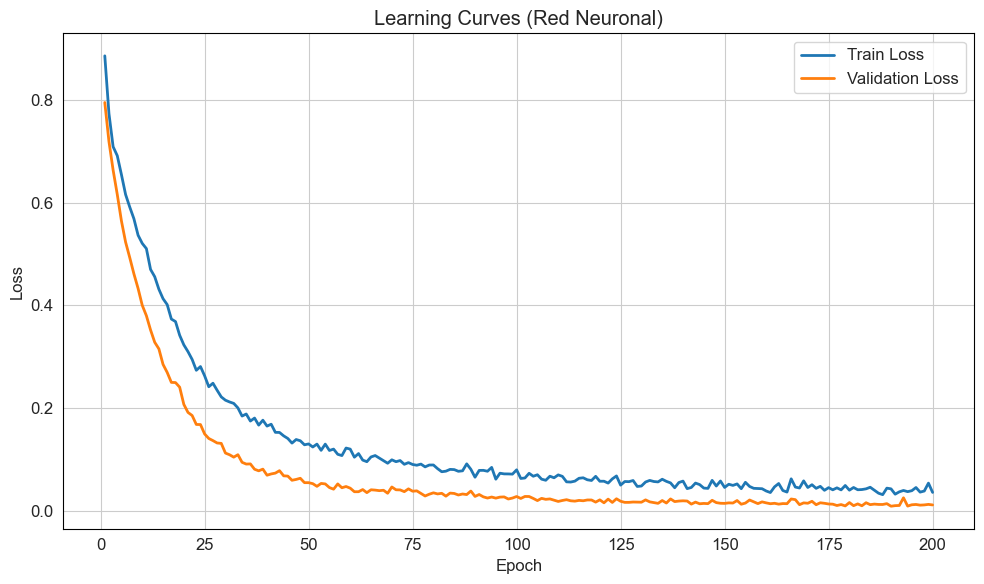

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves (Red Neuronal)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix

def evaluate(model, loader, y_true_tensor):
    model.eval()
    with torch.no_grad():
        logits = torch.cat([model(xb) for xb, _ in loader])
        probs  = torch.sigmoid(logits)
        preds  = (probs > 0.5).float()
        y_true = y_true_tensor.numpy()
        y_pred = preds.numpy()
        y_prob = probs.numpy()
        print(classification_report(y_true, y_pred, digits=3))
        print("ROC-AUC:", roc_auc_score(y_true, y_prob))

print("=== VALIDACIÓN ===")
evaluate(model, val_loader, y_val_tensor)

print("\n=== TEST ===")
evaluate(model, test_loader, y_test_tensor)

=== VALIDACIÓN ===
              precision    recall  f1-score   support

         0.0      1.000     0.998     0.999       525
         1.0      0.996     1.000     0.998       225

    accuracy                          0.999       750
   macro avg      0.998     0.999     0.998       750
weighted avg      0.999     0.999     0.999       750

ROC-AUC: 1.0

=== TEST ===
              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000       525
         1.0      1.000     1.000     1.000       225

    accuracy                          1.000       750
   macro avg      1.000     1.000     1.000       750
weighted avg      1.000     1.000     1.000       750

ROC-AUC: 1.0


In [21]:
# =====================================================
# 🔹 GUARDAR MODELOS ENTRENADOS
# =====================================================
import joblib

# Guarda modelos de scikit-learn
joblib.dump(bayes_logreg, "modelo_logistic.pkl")
joblib.dump(bayes_rf, "modelo_randomforest.pkl")

# Guarda modelo XGBoost
modelo_bayes_xgb.save_model("modelo_xgb.json")

# PyTorch
torch.save({
    "model_state_dict": model.state_dict(),
    "input_dim": input_dim  # guarda también la dimensión de entrada
}, "modelo_mlp.pth")

print("✅ Modelos guardados correctamente:")
print(" - modelo_logistic.pkl")
print(" - modelo_randomforest.pkl")
print(" - modelo_xgb.json")


✅ Modelos guardados correctamente:
 - modelo_logistic.pkl
 - modelo_randomforest.pkl
 - modelo_xgb.json
